In [1]:
from ipynb.fs.full.gbs import *

# Experiments

### Spoof Haar

```
                       ┌─────────────┐
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │ Haar-Random │──► [Detector]
[Detector] ◄──[ent]──► │   Unitary   │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
                       └─────────────┘
```

In [2]:
def spoof_haar(num_src, N=1000):
    m = 2*num_src
    ents = [ent(N, r=1) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    haar_U = qr_haar(m)
    r_ents = haar_U @ r_ents
    return threshold_detector(l_ents), threshold_detector(r_ents)

[[False False  True ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False  True]]


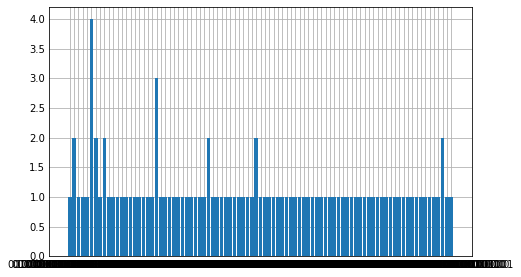

In [3]:
l_res, r_res = spoof_haar(10, N=100)
print(l_res)

def tup_to_bin(tup):
    return "".join(str(int(item)) for item in tup)

lcounts = get_all_coincidence_counts(l_res)
sortedCounts = []
bins = []
counts = []
for tup in lcounts:
    bins.append(tup_to_bin(tup))
    counts.append(lcounts[tup])
    sortedCounts.append((lcounts[tup], tup_to_bin(tup)))
plt.bar(bins, counts)
plt.show()
# print(sorted(sortedCounts, reverse=True))
# print(get_all_coincidence_counts(r_res))
# print_all_coincidence_counts(l_res)
# print_all_coincidence_counts(r_res)

In [4]:
print(ent(17,r=1))

(array([[-1.25647215-1.25231846j, -0.35434847+0.15023187j,
        -0.51308033-0.53780023j,  0.91783103+0.12810959j,
         0.48658029-0.40490021j, -0.21201508+0.49907842j,
        -0.85984929+0.13433901j, -0.84767611+0.50846433j,
         2.33517501+1.65922367j, -0.6208866 -0.52286391j,
        -0.8867792 -1.00115216j, -0.23675854-0.90608269j,
        -1.34764699+1.076299j  , -1.67728715-0.60906823j,
         1.04065054+1.10036619j, -0.34611347-0.48598907j,
         1.26294607-0.24600546j],
       [ 0.31616708-0.27724422j, -0.91230052-2.02355336j,
         0.26209533-0.89408795j,  1.4238355 -0.16616751j,
        -0.36565045+1.6738055j , -0.9411861 +0.73412822j,
        -1.21378688-0.4418689j , -1.09058713+1.4033607j ,
         0.45562012+0.03523013j,  0.7753312 -2.49741377j,
        -1.36745863-0.3454972j ,  0.60628454+1.32558095j,
         1.48652943+0.88784495j, -0.26608669-0.46854823j,
        -0.4662798 +2.04559614j, -0.81859141+1.26176201j,
         0.24272641-1.27293022j]]), a